Loading mesh...
Mesh loaded: 2503 vertices

Multigrid Hierarchy: 32 -> 128 -> 512 -> 1024 -> 2503
Number of modes: 10

Creating nested point hierarchy...
  Level 0: 32 points (nested)


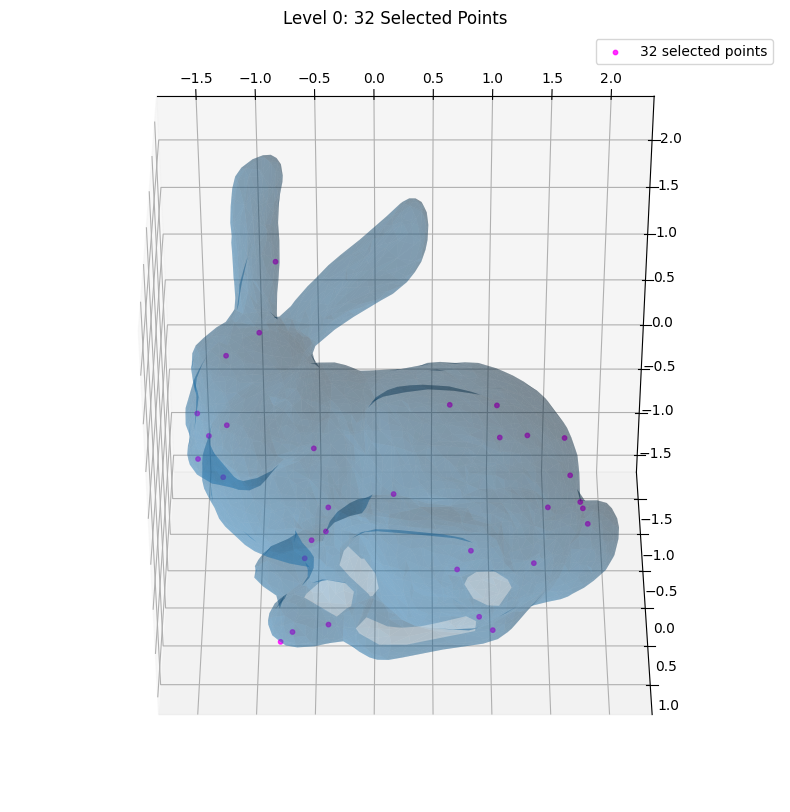

  Level 1: 128 points (nested)


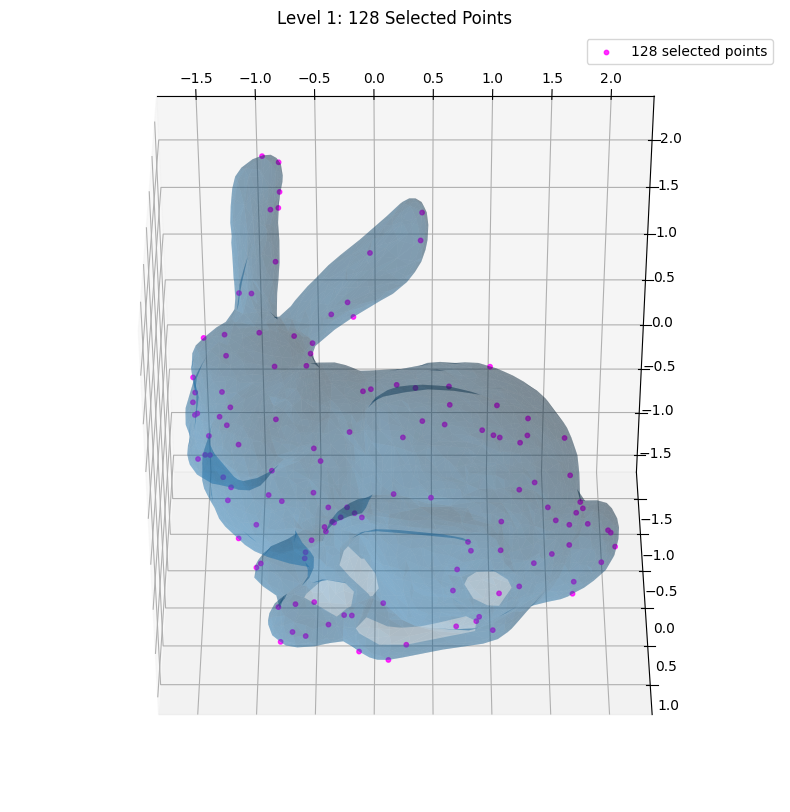

  Level 2: 512 points (nested)


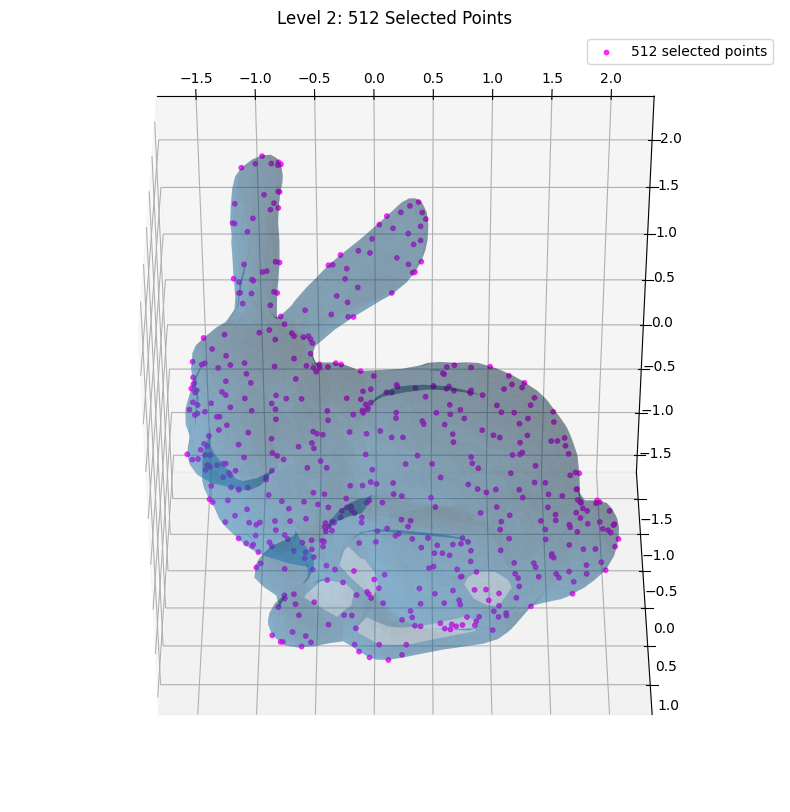

  Level 3: 1024 points (nested)


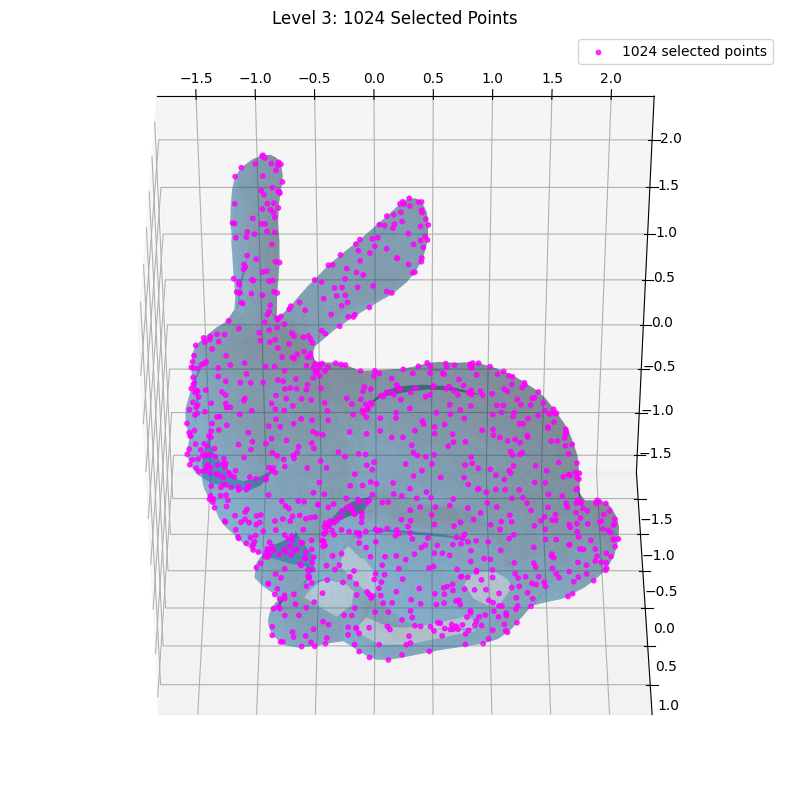

  Level 4: 2503 points (nested)


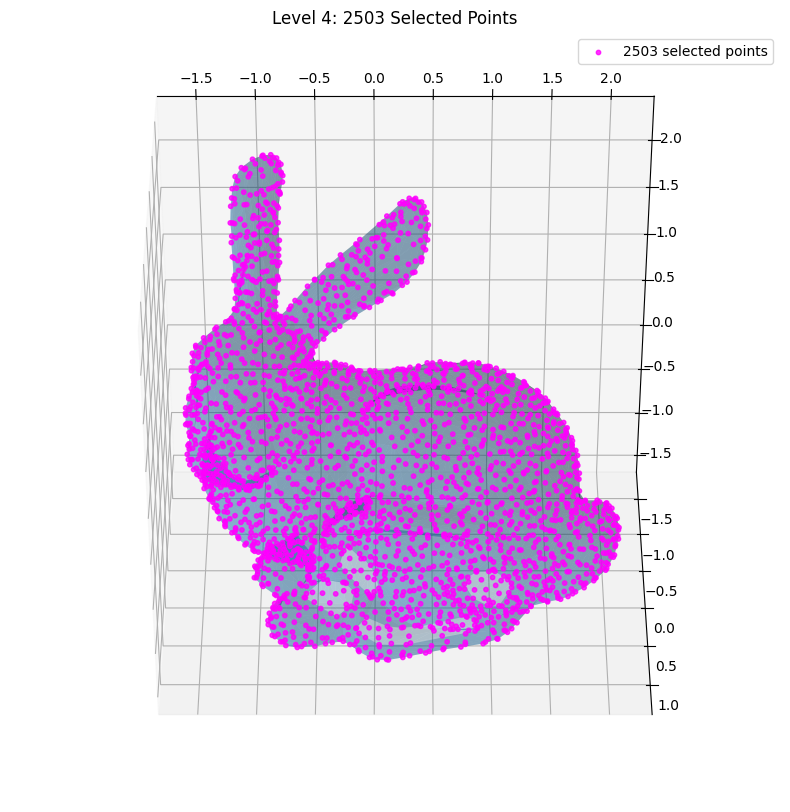


LEVEL 0: Coarse problem (32 points, 10 modes)
------------------------------------------------------------
Eigenvalues: [-0.000, 0.297, 0.804, 1.098, 1.368, 1.771, 1.991, 2.262, 2.745, 3.290]

LEVEL 1: Refining to 128 points
------------------------------------------------------------
  Computing Laplacian for 128 points...
  Building prolongation operator...
  Building kNN graph (k=4)...
  Creating new GNN model (hidden_dim=128, num_hidden_layers=3)...
  Training GNN (epochs=1500, lr=0.010000)...
    Epoch    0: Loss=570.322388 (Res=18.7872, Orth=38.2142, Proj=308.5636)
    Epoch  200: Loss=7.794048 (Res=0.7199, Orth=0.0483, Proj=112.6071)
    Epoch  400: Loss=3.590288 (Res=0.3005, Orth=0.0468, Proj=117.1874)
    Epoch  600: Loss=3.211997 (Res=0.2612, Orth=0.0477, Proj=123.1756)
    Epoch  800: Loss=1.401805 (Res=0.1111, Orth=0.0161, Proj=130.0224)
    Epoch 1000: Loss=1.087034 (Res=0.0727, Orth=0.0230, Proj=130.1360)
    Epoch 1200: Loss=0.443418 (Res=0.0288, Orth=0.0022, Proj=134.0

In [5]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import robust_laplacian
from Mesh import Mesh
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleGNN(nn.Module):
    """Simple GNN with message passing for eigenfunction refinement."""
    
    def __init__(self, in_dim, out_dim, hidden_dim=128, num_hidden_layers=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_hidden_layers = num_hidden_layers
        
        # Input layer
        self.fc_in = nn.Linear(in_dim * 2, hidden_dim)
        
        # Hidden layers (all same width)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        """
        Args:
            x: Node features [n_nodes, in_dim]
            edge_index: Edge indices [2, n_edges]
        Returns:
            Correction to eigenfunctions [n_nodes, out_dim]
        """
        row, col = edge_index
        
        # Aggregate neighbor features
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        
        # Concatenate node features with aggregated neighbor features
        x = torch.cat([x, agg], dim=1)
        
        # Input layer
        x = self.relu(self.fc_in(x))
        
        # Hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.relu(hidden_layer(x))
        
        # Output layer
        out = self.fc_out(x)
        return out
    
    def freeze_first_two_hidden_layers(self):
        """Freeze the first two hidden layers for final refinement."""
        if len(self.hidden_layers) >= 2:
            for param in self.hidden_layers[0].parameters():
                param.requires_grad = False
            for param in self.hidden_layers[1].parameters():
                param.requires_grad = False
            print(f"    Frozen: Hidden layers 1 and 2 (width={self.hidden_dim})")


class MultigridEigensolver:
    """Multigrid eigensolver using GNN for eigenfunction refinement."""
    
    def __init__(self, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model = None  # Shared model across all levels
    
    @staticmethod
    def normalize_mesh(mesh):
        """Center and normalize mesh vertices."""
        centroid = mesh.verts.mean(0)
        std_max = mesh.verts.std(0).max()
        verts_normalized = (mesh.verts - centroid) / std_max
        return Mesh(verts=verts_normalized, connectivity=mesh.connectivity)
    
    @staticmethod
    def sp_to_torch_sparse(A):
        """Convert scipy sparse matrix to torch sparse tensor."""
        A = A.tocoo()
        indices = np.vstack((A.row, A.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(A.data)
        return torch.sparse_coo_tensor(i, v, A.shape).coalesce()
    
    @staticmethod
    def build_prolongation(X_coarse, X_fine, k=1):
        """Build kNN-based prolongation operator from coarse to fine grid."""
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_coarse)
        distances, indices = nbrs.kneighbors(X_fine)
        
        n_fine, n_coarse = X_fine.shape[0], X_coarse.shape[0]
        rows, cols, vals = [], [], []
        
        for i in range(n_fine):
            # Inverse distance weighting
            weights = 1.0 / (distances[i] + 1e-12)
            weights /= weights.sum()
            
            for j, idx in enumerate(indices[i]):
                rows.append(i)
                cols.append(idx)
                vals.append(weights[j])
        
        return coo_matrix((vals, (rows, cols)), shape=(n_fine, n_coarse))
    
    @staticmethod
    def build_knn_graph(X, k=4):
        """Build kNN graph edge indices for GNN."""
        n_points = X.shape[0]
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, neighbors = nbrs.kneighbors(X)
        
        rows, cols = [], []
        for i in range(n_points):
            for j in neighbors[i][1:]:  # Skip self-loop
                rows.append(i)
                cols.append(j)
        
        return torch.LongTensor([rows, cols])
    
    @staticmethod
    def rayleigh_quotients(L, M, U):
        """Compute Rayleigh quotients for each column of U."""
        Lu = torch.sparse.mm(L, U)
        Mu = torch.sparse.mm(M, U)
        num = torch.sum(U * Lu, dim=0)
        den = torch.sum(U * Mu, dim=0) + 1e-12
        return num / den
    
    def solve_eigenvalue_problem(self, X, n_modes):
        """Solve eigenvalue problem on given points."""
        L, M = robust_laplacian.point_cloud_laplacian(X)
        eigenvalues, eigenvectors = eigsh(L, k=n_modes, M=M, which='SM')
        return eigenvalues, np.array(eigenvectors), L, M
    
    def train_gnn(self, model, x_feats, edge_index, U_init, L_fine, M_fine, 
                  U_coarse, P, n_modes, epochs=200, lr=1e-3, 
                  w_res=10.0, w_orth=1.0, w_proj=1.0):
        """Train GNN to refine eigenfunctions."""
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Convert to torch tensors
        U_init_t = torch.FloatTensor(U_init).to(self.device)
        L_fine_t = self.sp_to_torch_sparse(L_fine).to(self.device)
        M_fine_t = self.sp_to_torch_sparse(M_fine).to(self.device)
        U_coarse_t = torch.FloatTensor(U_coarse).to(self.device)
        R_t = self.sp_to_torch_sparse(P.T).to(self.device)
        I = torch.eye(n_modes).to(self.device)
        
        for ep in range(epochs):
            optimizer.zero_grad()
            
            # Predict correction
            corr = model(x_feats, edge_index)
            U_pred = U_init_t + corr
            
            # Compute Rayleigh quotients
            lambdas = self.rayleigh_quotients(L_fine_t, M_fine_t, U_pred)
            
            # Residual loss: ||L*U - M*U*Lambda||^2
            Lu = torch.sparse.mm(L_fine_t, U_pred)
            Mu = torch.sparse.mm(M_fine_t, U_pred)
            res = Lu - Mu * lambdas.unsqueeze(0)
            L_res = torch.sum(res**2) / (torch.sum(Mu**2) + 1e-12)
            
            # Orthonormality loss: ||U^T * M * U - I||^2
            MUt = torch.sparse.mm(M_fine_t, U_pred)
            Gram = U_pred.t() @ MUt
            L_orth = torch.sum((Gram - I)**2)
            
            # Projection loss: ensure consistency with coarse solution
            proj = R_t @ U_pred
            L_proj = torch.sum((proj - U_coarse_t)**2)
            
            # Total loss with configurable weights
            loss = w_res * L_res + w_orth * L_orth + w_proj * L_proj
            loss.backward()
            optimizer.step()
            
            if ep % 200 == 0:
                print(f"    Epoch {ep:4d}: Loss={loss.item():.6f} "
                      f"(Res={L_res.item():.4f}, Orth={L_orth.item():.4f}, Proj={L_proj.item():.4f})")
        
        return U_pred
    
    def refine_eigenvectors(self, U_pred, L_fine, M_fine):
        """Refine eigenvectors via Rayleigh-Ritz procedure."""
        L_fine_t = self.sp_to_torch_sparse(L_fine).to(self.device)
        M_fine_t = self.sp_to_torch_sparse(M_fine).to(self.device)
        
        # Detach U_pred from computation graph
        U_pred = U_pred.detach()
        
        # Compute A = U^T * L * U and B = U^T * M * U
        A = U_pred.t() @ torch.sparse.mm(L_fine_t, U_pred)
        B = U_pred.t() @ torch.sparse.mm(M_fine_t, U_pred)
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        
        # Solve small eigenvalue problem
        eigenvalues, C = eigh(A, B)
        U_refined = U_pred.cpu().numpy() @ C
        
        return eigenvalues, U_refined
    
    def refine_level(self, X_coarse, U_coarse, X_fine, n_modes, 
                     hidden_dim=128, num_hidden_layers=3,
                     k_neighbors=4, epochs=200, lr_start=1e-2, lr_min=1e-3,
                     w_res=10.0, w_orth=1.0, w_proj=1.0, level_idx=1, total_levels=5,
                     freeze_at_final_level=True):
        """Refine eigenfunctions from coarse to fine level with transfer learning."""
        n_fine = X_fine.shape[0]
        
        # Compute fine Laplacian and mass matrix
        print(f"  Computing Laplacian for {n_fine} points...")
        L_fine, M_fine = robust_laplacian.point_cloud_laplacian(X_fine)
        
        # Build prolongation operator
        print(f"  Building prolongation operator...")
        P = self.build_prolongation(X_coarse, X_fine, k=1)
        U_init = P @ U_coarse
        
        # Build GNN graph
        print(f"  Building kNN graph (k={k_neighbors})...")
        edge_index = self.build_knn_graph(X_fine, k=k_neighbors).to(self.device)
        
        # Initialize or reuse GNN model (Transfer Learning)
        in_dim = 3 + n_modes  # coords + coarse eigenfunctions
        
        if self.global_model is None:
            # First level - create new model
            print(f"  Creating new GNN model (hidden_dim={hidden_dim}, num_hidden_layers={num_hidden_layers})...")
            self.global_model = SimpleGNN(in_dim, n_modes, hidden_dim, num_hidden_layers).to(self.device)
        else:
            # Subsequent levels - reuse existing model
            print(f"  Reusing existing GNN model (transfer learning)...")
            # Freeze first two hidden layers ONLY at the final level
            if freeze_at_final_level and level_idx == total_levels - 1:
                self.global_model.freeze_first_two_hidden_layers()
        
        # Prepare input features
        x_feats = torch.FloatTensor(np.hstack([X_fine, U_init])).to(self.device)
        
        # Exponential decay: lr = lr_start * (lr_min/lr_start)^(level_idx / (total_levels - 2))
        if total_levels > 1:
            decay_factor = (level_idx - 1) / max(1, (total_levels - 2))
        else:
            decay_factor = 0
        adjusted_lr = lr_start * ((lr_min / lr_start) ** decay_factor)
        adjusted_lr = max(adjusted_lr, lr_min)  # Ensure we don't go below lr_min
        
        print(f"  Training GNN (epochs={epochs}, lr={adjusted_lr:.6f})...")
        
        # Train GNN
        U_pred = self.train_gnn(self.global_model, x_feats, edge_index, U_init, L_fine, M_fine, 
                                U_coarse, P, n_modes, epochs=epochs, lr=adjusted_lr,
                                w_res=w_res, w_orth=w_orth, w_proj=w_proj)
        
        # Refine eigenvectors
        print(f"  Applying Rayleigh-Ritz refinement...")
        lambda_refined, U_refined = self.refine_eigenvectors(U_pred, L_fine, M_fine)
        
        return lambda_refined, U_refined, L_fine, M_fine


def visualize_mesh(mesh, title='Mesh Visualization', highlight_indices=None):
    """Visualize mesh with vertices, optionally highlighting specific points."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # Plot full mesh with transparency
    ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:, 1], mesh.verts[:, 2], 
                    triangles=mesh.connectivity, alpha=0.3)
    
    # Highlight specific points if provided
    if highlight_indices is not None:
        highlighted_verts = mesh.verts[highlight_indices]
        ax.scatter(highlighted_verts[:, 0], highlighted_verts[:, 1], highlighted_verts[:, 2], 
                   c='fuchsia', s=10, alpha=0.8, label=f'{len(highlight_indices)} selected points')
        ax.legend()
    
    ax.set_title(title)
    ax.view_init(elev=130, azim=-90)
    plt.show()


def main():
    """Main execution pipeline with hierarchical multigrid."""
    # Load and normalize mesh
    print("Loading mesh...")
    mesh = Mesh('bunny.obj')
    mesh = MultigridEigensolver.normalize_mesh(mesh)
    X = mesh.verts
    n_total = X.shape[0]
    print(f"Mesh loaded: {n_total} vertices")
    
    # Initialize solver
    solver = MultigridEigensolver()
    
    # Configuration
    n_modes = 10
    hidden_dim = 128
    num_hidden_layers = 3
    k_neighbors = 4
    lr_start = 1e-2  # Starting learning rate
    lr_min = 1e-3    # Minimum learning rate
    
    # Epoch schedule
    epochs_schedule = {
        0: 0,      # Exact solve, no training
        1: 1500,   # 128 points
        2: 1000,   # 512 points
        3: 800,   # 1024 points
        4: 800    # 2503 points - freeze first 2 hidden layers
    }
    
    # Define hierarchy: 32 -> 128 -> 512 -> 1024 -> full
    hierarchy = [32, 128, 512, 1024, n_total]
    # Filter out levels larger than the mesh
    hierarchy = [n for n in hierarchy if n <= n_total]
    if hierarchy[-1] != n_total:
        hierarchy.append(n_total)
    
    print(f"\n{'='*60}")
    print(f"Multigrid Hierarchy: {' -> '.join(map(str, hierarchy))}")
    print(f"Number of modes: {n_modes}")
    print(f"{'='*60}\n")
    
    # Create nested indices upfront
    print("Creating nested point hierarchy...")
    all_indices = np.arange(n_total)
    np.random.shuffle(all_indices)
    
    indices_per_level = {}
    for level_idx_vis, n_points in enumerate(hierarchy):
        indices_per_level[level_idx_vis] = all_indices[:n_points].copy()
        print(f"  Level {level_idx_vis}: {n_points} points (nested)")
        
        # Visualize selected points for this level
        visualize_mesh(mesh, 
                      title=f'Level {level_idx_vis}: {n_points} Selected Points',
                      highlight_indices=indices_per_level[level_idx_vis])
    print()
    
    # Level 0: Solve coarse problem
    n_coarse = hierarchy[0]
    print(f"LEVEL 0: Coarse problem ({n_coarse} points, {n_modes} modes)")
    print("-" * 60)
    idx_coarse = indices_per_level[0]
    X_coarse = X[idx_coarse]
    
    lambda_current, U_current, L_current, M_current = solver.solve_eigenvalue_problem(X_coarse, n_modes)
    print(f"Eigenvalues: [{', '.join(f'{x:.3f}' for x in lambda_current)}]")
    print()
    
    # Iteratively refine through hierarchy
    for level_idx in range(1, len(hierarchy)):
        n_fine = hierarchy[level_idx]
        epochs = epochs_schedule.get(level_idx, 1000)  # Default to 1000 if not specified
        
        print(f"LEVEL {level_idx}: Refining to {n_fine} points")
        print("-" * 60)
        
        # Get nested fine points
        idx_fine = indices_per_level[level_idx]
        X_fine = X[idx_fine]
        
        # Refine from coarse to fine
        lambda_current, U_current, L_current, M_current = solver.refine_level(
            X_coarse, U_current, X_fine, n_modes,
            hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers,
            k_neighbors=k_neighbors, 
            epochs=epochs, lr_start=lr_start, lr_min=lr_min,
            w_res=10.0, w_orth=10.0, w_proj=0.001,
            level_idx=level_idx, total_levels=len(hierarchy),
            freeze_at_final_level=True
        )
        
        print(f"GNN eigenvalues:   [{', '.join(f'{x:.3f}' for x in lambda_current)}]")
        
        # Compute exact eigenvalues for verification
        print(f"  Computing exact eigenvalues for verification...")
        lambda_exact, _, _, _ = solver.solve_eigenvalue_problem(X_fine, n_modes)
        print(f"Exact eigenvalues: [{', '.join(f'{x:.3f}' for x in lambda_exact)}]")
        
        # Compute relative error
        rel_error = np.abs(lambda_current - lambda_exact) / (np.abs(lambda_exact) + 1e-12)
        print(f"Relative errors:   [{', '.join(f'{x:.3f}' for x in rel_error)}]")
        print()
        
        # Update for next level
        X_coarse = X_fine
    
    print(f"{'='*60}")
    print("Final Results")
    print(f"{'='*60}")
    print(f"Final eigenvalues: [{', '.join(f'{x:.3f}' for x in lambda_current)}]")
    print("\nDone!")


if __name__ == "__main__":
    main()